In [40]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import os,PIL,pathlib,random

使用PyTorch计算图像数据集的均值和方差

In [41]:
def getStat(train_data):
   
    print('Compute mean and variance for training data.')
    print(len(train_data))
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False, num_workers=0,
        pin_memory=True)
    print(train_loader)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    
    for X, _ in train_loader:
        for d in range(3):
            mean[d] += X[:, d, :, :].mean()
            std[d] += X[:, d, :, :].std()
    
    mean.div_(len(train_data))
    std.div_(len(train_data))
    return list(mean.numpy()), list(std.numpy())
    
    #return mean, std

In [42]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


train_dataset = datasets.ImageFolder('C:/Users/UNEXTINGUISHED/Desktop/492MLProject/data/train/', transform=transform)
print(getStat(train_dataset))

Compute mean and variance for training data.
1443
([0.70749766, 0.6953353, 0.690115], [0.23149869, 0.23226322, 0.23366533])


In [43]:
data_dir = 'C:/Users/UNEXTINGUISHED/Desktop/492MLProject/data'
data_dir = pathlib.Path(data_dir)

data_paths = list(data_dir.glob('*/*'))
classeNames = sorted(item.name for item in data_dir.glob('*/') if item.is_dir())
classeNames

#classes = ('adidas', 'converse', 'nike')

['test', 'train']

In [44]:
train_transforms = transforms.Compose([
    transforms.Resize([224, 224]),  
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),          
    transforms.Normalize(           
        mean=[0.70749766, 0.6953353, 0.690115], 
        std=[0.23149869, 0.23226322, 0.23366533]) 
])

test_transform = transforms.Compose([
    transforms.Resize([224, 224]),  # 将输入图片resize成统一尺寸
    transforms.ToTensor(),          # 将PIL Image或numpy.ndarray转换为tensor，并归一化到[0,1]之间
    transforms.Normalize(           # 标准化处理-->转换为标准正太分布（高斯分布），使模型更容易收敛
        mean=[0.718724, 0.70214254, 0.676997], 
        std=[0.21166055, 0.21455942, 0.22048959])  # 从数据集中随机抽样计算得到的。
])

train_dataset = datasets.ImageFolder("C:/Users/UNEXTINGUISHED/Desktop/492MLProject/data/train/",transform=train_transforms)
test_dataset  = datasets.ImageFolder("C:/Users/UNEXTINGUISHED/Desktop/492MLProject/data/test/",transform=train_transforms)

In [45]:
train_dataset.class_to_idx

{'adidas': 0, 'converse': 1, 'nike': 2}

In [46]:
print(train_dataset)

Dataset ImageFolder
    Number of datapoints: 1443
    Root location: C:/Users/UNEXTINGUISHED/Desktop/492MLProject/data/train/
    StandardTransform
Transform: Compose(
               Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.70749766, 0.6953353, 0.690115], std=[0.23149869, 0.23226322, 0.23366533])
           )


In [47]:
#划分数据集
batch_size = 32

train_dl = torch.utils.data.DataLoader(train_dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=1)
test_dl = torch.utils.data.DataLoader(test_dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=1)
for X, y in test_dl:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([32, 3, 224, 224])
Shape of y:  torch.Size([32]) torch.int64


In [2]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=0), # 12*220*220
            nn.BatchNorm2d(12),
            nn.ReLU())
        
        self.conv2=nn.Sequential(
            nn.Conv2d(12, 12, kernel_size=5, padding=0), # 12*216*216
            nn.BatchNorm2d(12),
            nn.ReLU())
        
        self.pool3=nn.Sequential(
            nn.MaxPool2d(2))                              # 12*108*108
        
        self.conv4=nn.Sequential(
            nn.Conv2d(12, 24, kernel_size=5, padding=0), # 24*104*104
            nn.BatchNorm2d(24),
            nn.ReLU())
        
        self.conv5=nn.Sequential(
            nn.Conv2d(24, 24, kernel_size=5, padding=0), # 24*100*100
            nn.BatchNorm2d(24),
            nn.ReLU())
        
        self.pool6=nn.Sequential(
            nn.MaxPool2d(2))                              # 24*50*50

        self.dropout = nn.Sequential(
            nn.Dropout(0.1))
        
        self.fc=nn.Sequential(
            #nn.Linear(24*50*50, len(classeNames)))
            nn.Linear(24*50*50, 3))
        
    def forward(self, x):
        
        batch_size = x.size(0)
        x = self.conv1(x)  
        x = self.conv2(x)  
        x = self.pool3(x)
        x = self.conv4(x)  
        x = self.conv5(x)  
        x = self.pool6(x)  
        x = self.dropout(x)
        x = x.view(batch_size,-1)  
        x = self.fc(x)

        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model = Model().to(device)
model

NameError: name 'nn' is not defined

In [49]:

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)  
    num_batches = len(dataloader)   

    train_loss, train_acc = 0, 0 
    
    for X, y in dataloader: 
        X, y = X.to(device), y.to(device)
        
     
        pred = model(X)         
        loss = loss_fn(pred, y)  
        
        optimizer.zero_grad()  
        loss.backward()        
        optimizer.step()       
        
        
        train_acc  += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()

    train_acc  /= size
    train_loss /= num_batches

    return train_acc, train_loss

In [50]:
def test (dataloader, model, loss_fn):
    size        = len(dataloader.dataset)  
    num_batches = len(dataloader)          
    test_loss, test_acc = 0, 0
    
    
    with torch.no_grad():
        for imgs, target in dataloader:
            imgs, target = imgs.to(device), target.to(device)
            
            
            target_pred = model(imgs)
            loss        = loss_fn(target_pred, target)
            
            test_loss += loss.item()
            test_acc  += (target_pred.argmax(1) == target).type(torch.float).sum().item()

    test_acc  /= size
    test_loss /= num_batches

    return test_acc, test_loss

In [51]:
def adjust_learning_rate(optimizer, epoch, start_lr):
    
    lr = start_lr * (0.97 ** (epoch // 2))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

learn_rate = 0.0001 
optimizer  = torch.optim.SGD(model.parameters(), lr=learn_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

In [52]:
loss_fn    = nn.CrossEntropyLoss() 
epochs     = 200

train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []
test_top1_acc = 0 

for epoch in range(epochs):
    
    #adjust_learning_rate(optimizer, epoch, learn_rate)
    
    model.train()
    epoch_train_acc, epoch_train_loss = train(train_dl, model, loss_fn, optimizer)
    # scheduler.step() 
    
    model.eval()
    epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn)
    
    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    
    if epoch_test_acc > test_top1_acc:
        test_top1_acc = epoch_test_acc
        
    
    lr = optimizer.state_dict()['param_groups'][0]['lr']
    
    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%, Test_loss:{:.3f}, Lr:{:.2E}')
    print(template.format(epoch+1, epoch_train_acc*100, epoch_train_loss, 
                            epoch_test_acc*100, epoch_test_loss, lr))
print('Done')
print('Test_top1_acc:',test_top1_acc)

Epoch: 1, Train_acc:38.3%, Train_loss:1.144, Test_acc:34.2%, Test_loss:1.385, Lr:1.00E-04
Epoch: 2, Train_acc:50.2%, Train_loss:1.023, Test_acc:37.7%, Test_loss:1.332, Lr:1.00E-04
Epoch: 3, Train_acc:55.5%, Train_loss:0.937, Test_acc:45.6%, Test_loss:1.058, Lr:1.00E-04
Epoch: 4, Train_acc:59.0%, Train_loss:0.900, Test_acc:48.2%, Test_loss:1.019, Lr:1.00E-04
Epoch: 5, Train_acc:61.8%, Train_loss:0.865, Test_acc:42.1%, Test_loss:1.397, Lr:1.00E-04
Epoch: 6, Train_acc:64.6%, Train_loss:0.841, Test_acc:50.9%, Test_loss:1.099, Lr:1.00E-04
Epoch: 7, Train_acc:67.0%, Train_loss:0.795, Test_acc:48.2%, Test_loss:1.198, Lr:1.00E-04
Epoch: 8, Train_acc:67.4%, Train_loss:0.783, Test_acc:49.1%, Test_loss:1.234, Lr:1.00E-04
Epoch: 9, Train_acc:69.2%, Train_loss:0.763, Test_acc:49.1%, Test_loss:1.058, Lr:1.00E-04
Epoch:10, Train_acc:71.5%, Train_loss:0.720, Test_acc:52.6%, Test_loss:1.013, Lr:1.00E-04
Epoch:11, Train_acc:72.6%, Train_loss:0.684, Test_acc:57.0%, Test_loss:0.936, Lr:1.00E-04
Epoch:12, 

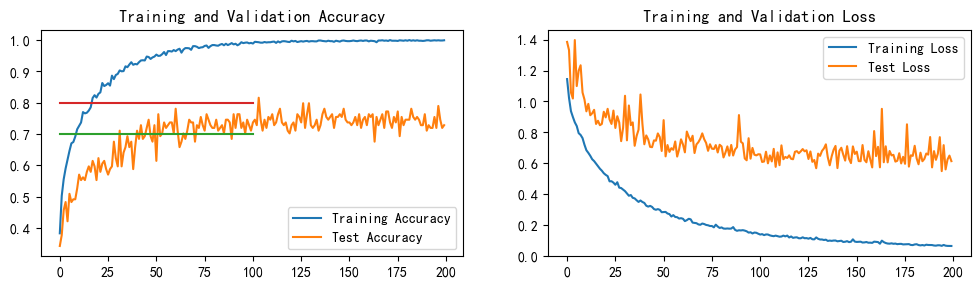

In [53]:
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")              
plt.rcParams['font.sans-serif']    = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False     
plt.rcParams['figure.dpi']         = 100        

epochs_range = range(epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.plot([0,100],[0.7,0.7])
plt.plot([0,100],[0.8,0.8])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

进行预测

In [54]:
from PIL import Image 

classes = list(train_dataset.class_to_idx)

def predict_one_image(image_path, model, transform, classes):
    
    test_img = Image.open(image_path).convert('RGB')
    #plt.imshow(test_img)  

    test_img = transform(test_img)
    img = test_img.to(device).unsqueeze(0)
    
    model.eval()
    output = model(img)

    _,pred = torch.max(output,1)
    pred_class = classes[pred]
    print(f'Predict result：{pred_class}')

In [55]:

predict_one_image(image_path='C:/Users/UNEXTINGUISHED/Desktop/492MLProject/data/test/nike/3.jpg', 
                    model=model, 
                    transform=train_transforms, 
                    classes=classes)



Predict result：nike


In [56]:

PATH = 'C:/Users/UNEXTINGUISHED/Desktop/492MLProject/Brands_model_final.pth'  
torch.save(model.state_dict(), PATH)


#model.load_state_dict(torch.load(PATH, map_location=device))

Test model.py


In [4]:
import torch
from torchvision import transforms
import torch.nn as nn
from PIL import Image
import os
import numpy as np

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=0), # 12*220*220
            nn.BatchNorm2d(12),
            nn.ReLU())
        
        self.conv2=nn.Sequential(
            nn.Conv2d(12, 12, kernel_size=5, padding=0), # 12*216*216
            nn.BatchNorm2d(12),
            nn.ReLU())
        
        self.pool3=nn.Sequential(
            nn.MaxPool2d(2))                              # 12*108*108
        
        self.conv4=nn.Sequential(
            nn.Conv2d(12, 24, kernel_size=5, padding=0), # 24*104*104
            nn.BatchNorm2d(24),
            nn.ReLU())
        
        self.conv5=nn.Sequential(
            nn.Conv2d(24, 24, kernel_size=5, padding=0), # 24*100*100
            nn.BatchNorm2d(24),
            nn.ReLU())
        
        self.pool6=nn.Sequential(
            nn.MaxPool2d(2))                              # 24*50*50

        self.dropout = nn.Sequential(
            nn.Dropout(0.1))
        
        self.fc=nn.Sequential(
            #nn.Linear(24*50*50, len(classeNames)))
            nn.Linear(24*50*50, 3))
        
    def forward(self, x):
        
        batch_size = x.size(0)
        x = self.conv1(x)  
        x = self.conv2(x)  
        x = self.pool3(x)
        x = self.conv4(x)  
        x = self.conv5(x)  
        x = self.pool6(x)  
        x = self.dropout(x)
        x = x.view(batch_size,-1)  
        x = self.fc(x)

        return x
    
    
test_images_dir = "C:/Users/UNEXTINGUISHED/Desktop/492MLProject/data/test"  
model_path = "C:/Users/UNEXTINGUISHED/Desktop/492MLProject/Brands_model_final.pth"  
output_file_path = "C:/Users/UNEXTINGUISHED/Desktop/492MLProject/TestList.txt"

device = "cuda" if torch.cuda.is_available() else "cpu"
model = Model().to(device)
model.load_state_dict(torch.load(model_path))
#model = model
model.eval()
class_name = ['A', 'C', 'N']

transform = transforms.Compose([
    transforms.Resize([224, 224]),  
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),          
    transforms.Normalize(           
        mean=[0.70749766, 0.6953353, 0.690115], 
        std=[0.23149869, 0.23226322, 0.23366533]) 
])

output_dir = os.path.dirname(output_file_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


with open(output_file_path, 'w') as f:
    
    for class_dir in os.listdir(test_images_dir):
        
        class_images = [os.path.join(test_images_dir, class_dir, img) for img in os.listdir(os.path.join(test_images_dir, class_dir)) if img.endswith('.jpg')]  # 假设图片是.jpg格式，您可以根据需要修改

        
        for image_path in class_images:
            
            img = Image.open(image_path)
            img_tensor = transform(img).unsqueeze(0)

           
            with torch.no_grad():
                predictions = model(img_tensor.to(device))
            predicted_class = torch.argmax(predictions[0]).item()

            predicted_class_name = class_name[predicted_class]

            
            image_parts = os.path.split(image_path)
            category_from_path = image_parts[0].split('/')[-1]
            image_name_from_path = image_parts[1]

            
            output_line = f'Predicted class for {image_name_from_path} in {category_from_path} is: {predicted_class_name}\n'
            f.write(output_line)